In [225]:
import pandas as pd
import numpy as np
import datetime
import time

In [226]:
%matplotlib inline

## 1 探索

In [227]:
path = r"C:\Users\corem\Documents\风险平价参考\风险平价参考\data.csv"
df = pd.read_csv(path)

In [228]:
df.head()

,TradeDate,000300.SH,399905.SZ,HSCEI.HI,NDX.GI,SPX.GI,GDAXI.GI,AU9999.SGE,TERGLU.FI,SPGOGUP.SPI,930849.CSI,H11008.CSI
0,2008/1/2,5385.103,5123.934,16006.81,2093.21,1447.16,7949.11,196.46,1099.199951,3185.50,100.261,112.65
1,2008/1/3,5422.034,5230.749,15464.66,2051.76,1447.16,7908.41,200.80,1074.010010,3215.46,100.954,112.85
2,2008/1/4,5483.650,5243.032,15903.40,1963.52,1411.63,7808.69,202.50,1044.819946,3155.92,100.603,113.11
3,2008/1/7,5556.593,5347.790,15590.74,1957.44,1416.18,7817.17,200.26,1035.969971,3140.74,100.661,112.94
4,2008/1/8,5528.054,5200.552,15659.71,1910.33,1390.19,7849.99,203.90,1014.929993,3124.21,100.696,112.67


In [229]:
#a=['TradeDate', '000300.SH','399905.SZ','NDX.GI','SPX.GI','GDAXI.GI','TERGLU.FI']

In [230]:
#df=df[a]

In [231]:
df['TradeDate'] = pd.to_datetime(df['TradeDate'])
#df.index = pd.DatetimeIndex(df.index)
df = df.set_index('TradeDate')

### 绘制各指数走势

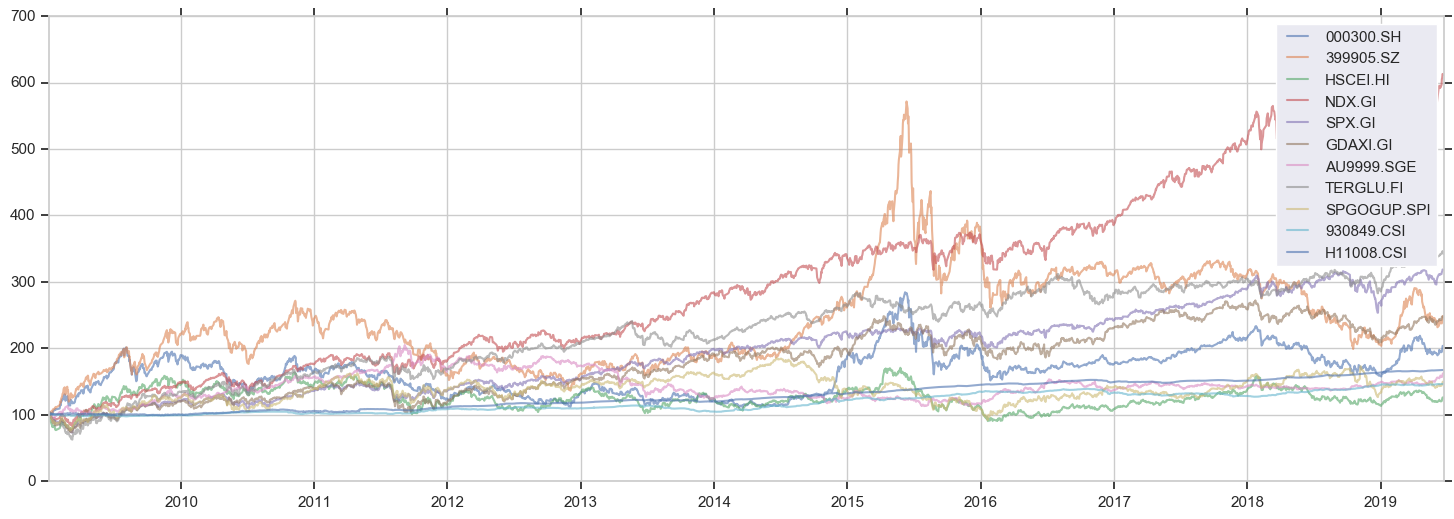

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
#style.use('fivethirtyeight')
#style.use('ggplot')
sns.set_style("whitegrid")
#sns.color_palette("hls", 12)
#sns.set(style ='darkgrid',palette ='deep')
fig, axes = plt.subplots(1,1,figsize=(18, 6))

def plot(data):
    sns.set(palette="muted")
    plt.plot(data, label=data.name, alpha=.6)
    plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False  
data = df['2009-01-01':]
data = data/data.iloc[0]*100 # 统一缩放到100为基点    
data.apply(plot)
plt.legend() 
plt.show()

### 计算收益率
将指数价格转换为收益率。这里采用简单收益率：

> $R_{t}=\frac{P_{t}-P_{t-1}}{P_{t-1}}$

In [233]:
def get_return_df(df):
    returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
    # returns_df = np.log(df/df.shift(1)) # 对数收益率
    returns_df.dropna(axis='index', inplace=True) # 删除空数据
    return returns_df
index_return = get_return_df(df)


### 查看收益率分布直方图

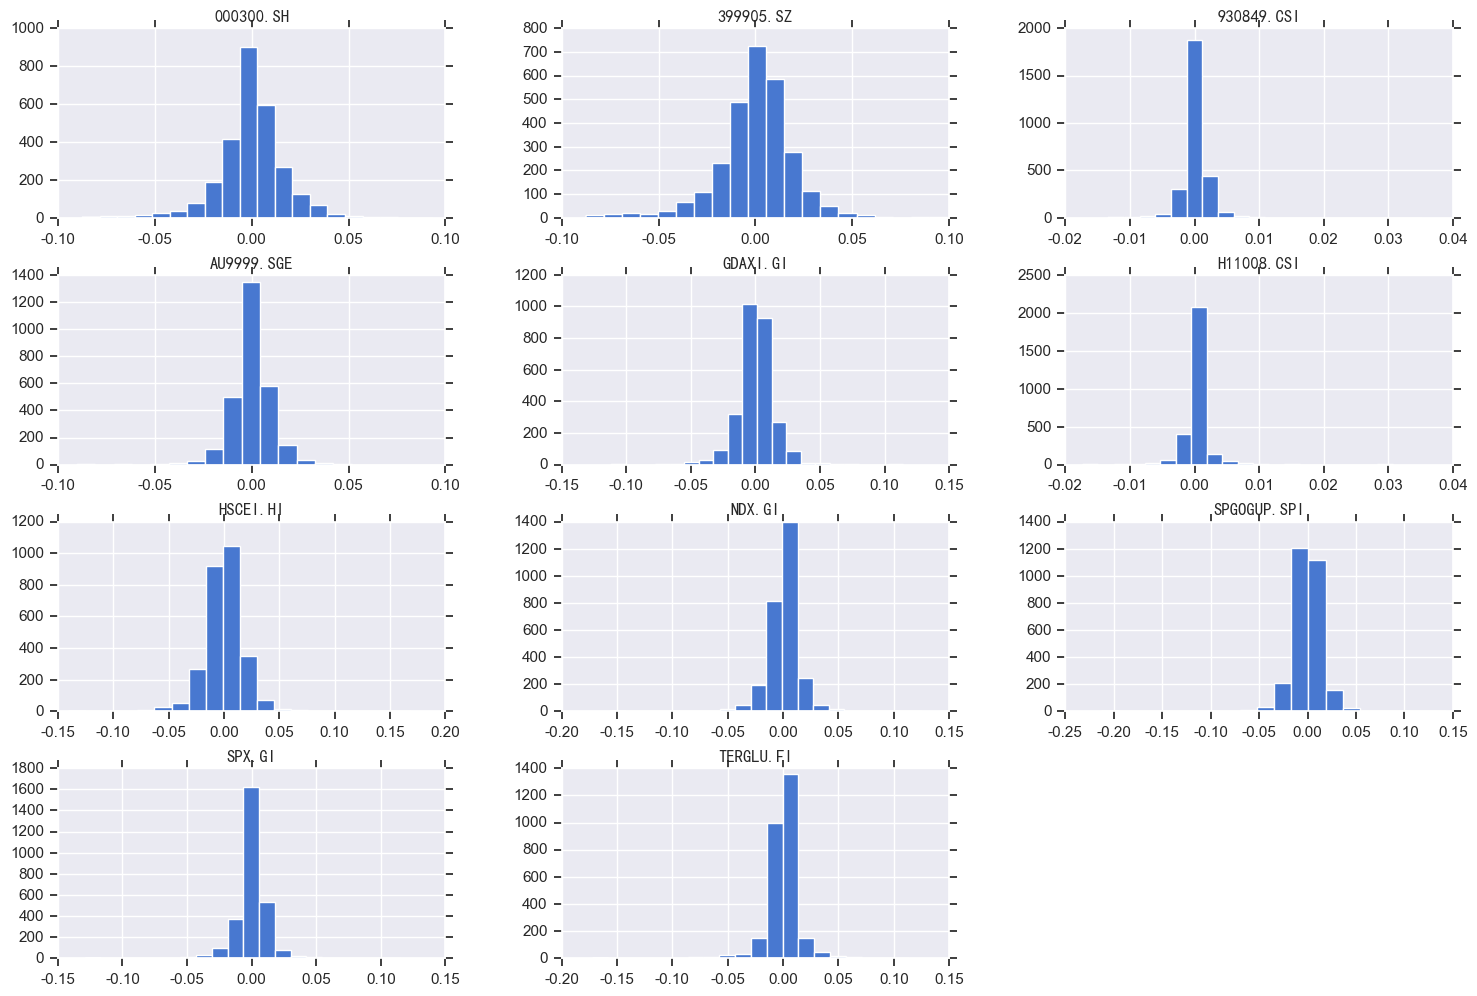

In [234]:
hist = index_return.hist(bins=20, figsize=(18, 12)) # 查看收益率分布
plt.show()

### 相关系数
相关系数$\rho_{A,B}=\frac{\sigma_{AB}}{\sigma_{A}\sigma_{B}}$ 

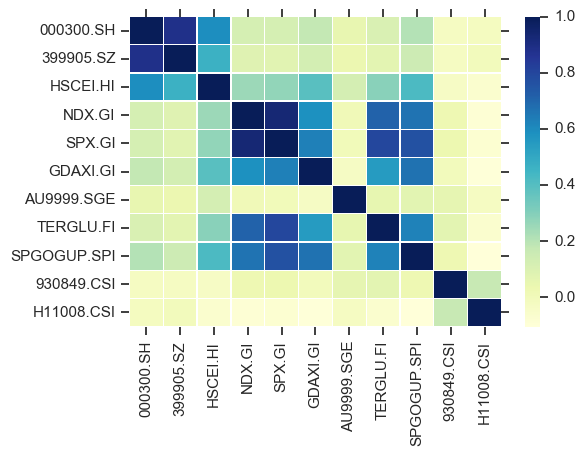

In [235]:
corr = index_return.corr()
corr_heatmap = sns.heatmap(corr, cmap="YlGnBu", linewidths=.2)
plt.show()

## 2 模型

回测区间：2009年1月1日至2019年6月25日（其中2009年数据用于初期样本内的计算）；

调仓时间：每季度末最后一个交易日；

样本窗口：每个调仓前240个哦交易日；

资产配置模型：等权重资产配置模型(EW)，标准风险平价模型(RP)，主成分风险平价模型(PCRP)，引入预期风险估计的半衰风险平价模型(HRP)，引入预期风险估计的半衰主成分风险平价模型(HPCRP)，引入预期走势估计的主成分风险平价模型(TF-PCRP)，引入惩罚项的风险平价模型(lasso_RP)

### 2.1 等权重资产配置模型  EW

权重 $w_i=\frac{1}{N}$

In [236]:
def ew_weight_matrix(df):
    """返回等权重资产配置矩阵"""
    period_type = 'Q'
    df_weight= df.resample(period_type).last()
    df_weight = df_weight[df_weight.index>='2008-12-31']
    df_weight.iloc[:,:] = 1/df_weight.shape[1]        
    return df_weight

#### 模型权重分布

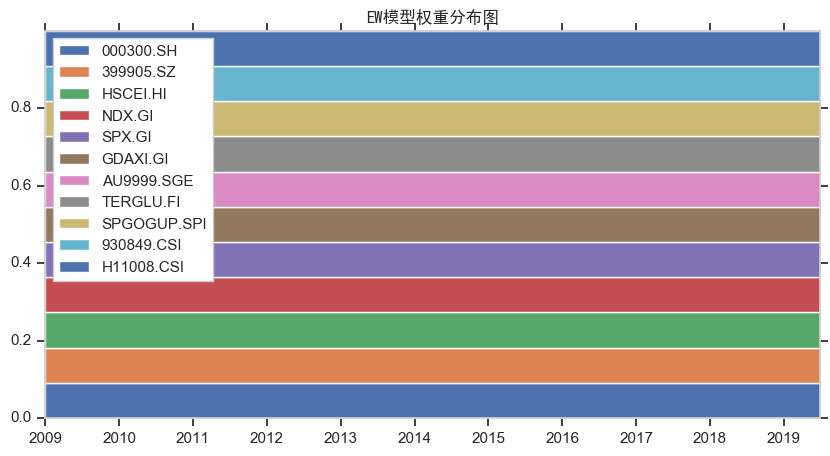

In [237]:
ew_weight = ew_weight_matrix(df)
sns.set(style="whitegrid")
labels = ew_weight.columns.to_list()
fig, ax = plt.subplots(figsize=(10,5))
plt.title("EW模型权重分布图")
plt.yticks(np.arange(0, 1, step=0.2))
ax.stackplot(ew_weight.index, ew_weight.T,baseline='zero',labels=labels)
ax.legend(loc='upper left')
plt.show()

### 2.2  标准风险平价模型  RP 

In [250]:
from sklearn.covariance import EmpiricalCovariance
from sklearn.datasets import make_gaussian_quantiles

In [252]:
real_cov = np.array([[.8, .3],[.3, .4]])

In [253]:
rng = np.random.RandomState(0)
X = rng.multivariate_normal(mean=[0, 0],cov=real_cov,size=500)

In [255]:
X.shape

(500, 2)

In [264]:
cov = EmpiricalCovariance().fit(returns_df)

In [258]:
df = df.loc[df.index<'2008-12-31'] 
df = df.iloc[-240:] #每个调仓前240个交易日

In [261]:
df = df/df.iloc[0]*100 # 统一缩放到100为基点
returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
    # returns_df = np.log(df/df.shift(1)) # 对数收益率
returns_df.dropna(axis='index', inplace=True) # 删除空数据

In [263]:
returns_df.shape

(239, 11)

In [247]:
def calculate_cov_matrix(df):
    """计算协方差矩阵"""
    df = df/df.iloc[0]*100 # 统一缩放到100为基点
    returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
    # returns_df = np.log(df/df.shift(1)) # 对数收益率
    returns_df.dropna(axis='index', inplace=True) # 删除空数据
    one_cov_matrix = returns_df.cov()*240
    return np.matrix(one_cov_matrix)

In [239]:
def get_train_set(change_time,df):
    """返回训练样本数据"""
# change_time: 调仓时间
    df = df.loc[df.index<change_time] 
    df = df.iloc[-240:] #每个调仓前240个交易日
    return df 

#### 标准风险平价下要优化的目标函数
$min \sum_{i=1}^{n} \sum_{j=1}^{n} [w_i(\Sigma w)_i - w_j(\Sigma w)_j ]^2$

subject to $\sum_{i=1}^{n}w_i =1, ~~ 0\le w_i \le 1$

总的风险贡献就是组合的波动率$\sigma_p$，设有n个资产，风险平价下，即每个资产的风险贡献等于$\frac{1}{n}\sigma_p$

$min \sum_{i=1}^{n}[RC_i - \frac{1}{n} \sigma_p ]^2$

其中 $RC_i = w_i \frac{(\Sigma w)_i}{\sqrt{w^T \Sigma w}}$

In [240]:
# 标准风险平价下的风险贡献
def calculate_risk_contribution(weight,one_cov_matrix):
    weight=np.matrix(weight) 
    sigma=np.sqrt(weight*one_cov_matrix*weight.T)
    # 边际风险贡献 Marginal Risk Contribution (MRC)
    MRC=one_cov_matrix*weight.T/sigma
    # 风险贡献 Risk Contribution (RC)
    RC=np.multiply(MRC,weight.T)
    return RC

In [241]:
import scipy.optimize as sco
import scipy.interpolate as sci

# 定义优化问题的目标函数，即最小化资产之间的风险贡献差
def naive_risk_parity(weight,parameters): 
    # weight: 待求解的资产权重,
    # parameters: 参数列表 
    # parameters[0]: 协方差矩阵
    # parameters[1]: 风险平价下的目标风险贡献度向量

    one_cov_matrix=parameters[0]
    RC_target_ratio=parameters[1] 
    # RC_target为风险平价下的目标风险贡献，一旦参数传递以后，RC_target就是一个常数，不随迭代而改变
    sigma_portfolio=np.sqrt(weight*one_cov_matrix*np.matrix(weight).T) # 组合波动率
    RC_target=np.asmatrix(np.multiply(sigma_portfolio,RC_target_ratio))    # 目标风险贡献
    # RC_real是 每次迭代以后最新的真实风险贡献，随迭代而改变
    RC_real=calculate_risk_contribution(weight,one_cov_matrix)
    sum_squared_error= sum(np.square(RC_real-RC_target.T))[0,0] 
    return sum_squared_error 

In [242]:
# 根据资产预期目标风险贡献度来计算各资产的权重
def calculate_portfolio_weight(one_cov_matrix,risk_budget_objective):
    '''
约束条件的类型只有'eq'和'ineq'两种
eq表示约束方程的返回结果为0
ineq表示约束方程的返回结果为非负数
'''
    num = data.shape[1]
    x0 = np.array([1.0 / num for _ in range(num)]) # 初始资产权重
    bounds = tuple((0, 1) for _ in range(num))     # 取值范围(0,1)

    cons_1 = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},)   #权重和为1
    RC_set_ratio = np.array([1.0 / num for _ in range(num)])   #风险平价下每个资产的目标风险贡献度相等
    optv = sco.minimize(risk_budget_objective, x0, args=[one_cov_matrix,RC_set_ratio], method='SLSQP', bounds=bounds, constraints=cons_1)
    return optv.x

In [243]:
def get_weight_matrix(df,method=None,half=False):
    """返回资产权重矩阵"""
    period_type = 'Q'
    df_weight= df.resample(period_type).last()
    df_weight = df_weight[df_weight.index>='2008-12-31']
            
    for i in range(len(df_weight.index)):
        change_time = df_weight.index[i]

    #next_change_time = df_weight.index[i+1]
        train_set = get_train_set(change_time,df)
        # 是否使用半衰协方差矩阵
        if half == True:
            one_cov_matrix = calculate_half_cov_matrix(train_set)
        else:
            one_cov_matrix = calculate_cov_matrix(train_set)
        # 是否使用主成分分析
        if method == 'pca':
            df_weight.iloc[i] = calculate_portfolio_weight(one_cov_matrix,pca_risk_parity)
        elif method =='lasso':
            df_weight.iloc[i] = calculate_portfolio_weight(one_cov_matrix,lasso_risk_parity)
        else:
            df_weight.iloc[i] = calculate_portfolio_weight(one_cov_matrix,naive_risk_parity)
        #backtest_set = get_backtest_set(change_time,next_change_time,df)    
        #df_weight.iloc[i] = calculate_portfolio_weight(one_cov_matrix) 
    return df_weight

#### 模型权重分布

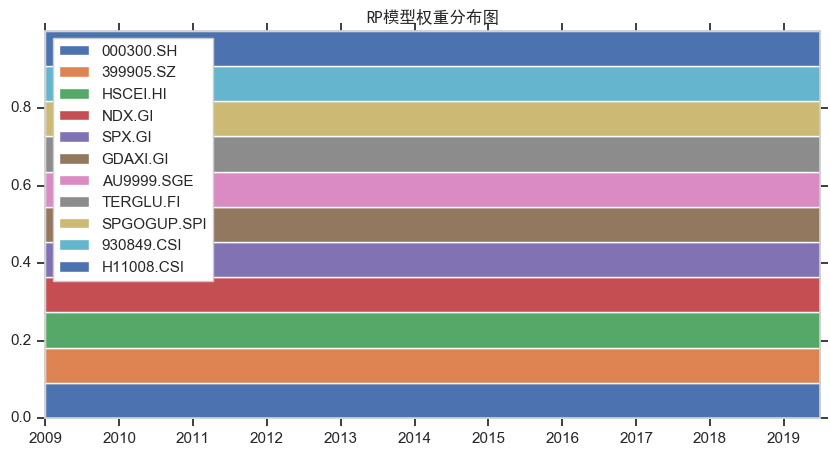

In [244]:
df_weight_rp = get_weight_matrix(df,method=None)
#plt.style.context('Solarize_Light2')
for i in range(df_weight_rp.shape[0]):
    df_weight_rp.iloc[i] = df_weight_rp.iloc[i]/df_weight_rp.iloc[i].sum()
labels = df_weight_rp.columns.to_list()
fig, ax = plt.subplots(figsize=(10,5))
#variable_name = list(dict(df=df).keys())[0]
#variable_name = variable_name.split("_")[-1]
plt.title("RP模型权重分布图")
plt.yticks(np.arange(0, 1, step=0.2))
ax.stackplot(df_weight_rp.index, df_weight_rp.T,baseline='zero',labels=labels)
ax.legend(loc='upper left')
plt.show()

### 2.3 主成分风险平价模型  PCRP

标准风险平价有一些缺陷，例如1.模型要求资产间的相关性尽可能低，但是事实上现有资产间的相关性是非常高的，2.模型会在所有资产间分配权重，即便投资标

的中有两种相关性极高的资产。

针对这两个问题，可以使用主成分分析的方法，对原始资产线性变化形成互不相关的资产组合。

设原始变量是$x$,主成分分析是一种线性变换手段，主要是使得变换后的变量$\beta x$的方差最大，

$Var(\beta x)=\beta^t \Sigma \beta$，其中$\Sigma$是协方差矩阵，显然就是

$f(\beta)=\beta^t \Sigma \beta +\lambda (1-\beta^t\beta)$

这是一个拉格朗日乘子式，求导就能得到$\beta$就是$\Sigma$的特征向量，进而主成分线性无关。

#### 基于主成分分析的风险平价下要优化的目标函数 

与简单风险平价相比，区别在于修改风险贡献  

$RC_{PC,i}=\frac{(E^T w)_i \dot (E^T \Sigma w)_i}{\sqrt{w^T \Sigma w}}$   

其中 $E \Delta E^T = \Sigma$

In [195]:
# 基于主成分分析的风险平价下的风险贡献
def calculate_risk_contribution_pca(weight,one_cov_matrix):
    weight=np.matrix(weight) 
    sigma=np.sqrt(weight*one_cov_matrix*weight.T)
    # 奇异值分解，其中uv=I ,u,v是特征向量矩阵，是正交阵，d是对角矩阵，对角元素是特征值，tr(d)=tr(one_cov_matrix)
    u,d,v = np.linalg.svd(one_cov_matrix)
    a = v*weight.T
    b=v*(one_cov_matrix*weight.T)
    # 风险贡献 Risk Contribution (RC)
    RC=np.multiply(a,b)
    RC=RC/sigma
    return RC

In [196]:
# 定义优化问题的目标函数，即最小化资产之间的风险贡献差
def pca_risk_parity(weight,parameters):
    # weight: 待求解的资产权重,
    # parameters: 参数列表 
    # parameters[0]: 协方差矩阵
    # parameters[1]: 风险平价下的目标风险贡献度向量

    one_cov_matrix=parameters[0]
    RC_target_ratio=parameters[1] 
    # RC_target为风险平价下的目标风险贡献，一旦参数传递以后，RC_target就是一个常数，不随迭代而改变
    sigma_portfolio=np.sqrt(weight*one_cov_matrix*np.matrix(weight).T) # 组合波动率
    RC_target=np.asmatrix(np.multiply(sigma_portfolio,RC_target_ratio))    # 目标风险贡献
    # RC_real是 每次迭代以后最新的真实风险贡献，随迭代而改变
    RC_real=calculate_risk_contribution_pca(weight,one_cov_matrix)
    sum_squared_error= sum(np.square(RC_real-RC_target.T))[0,0] 
    return sum_squared_error     

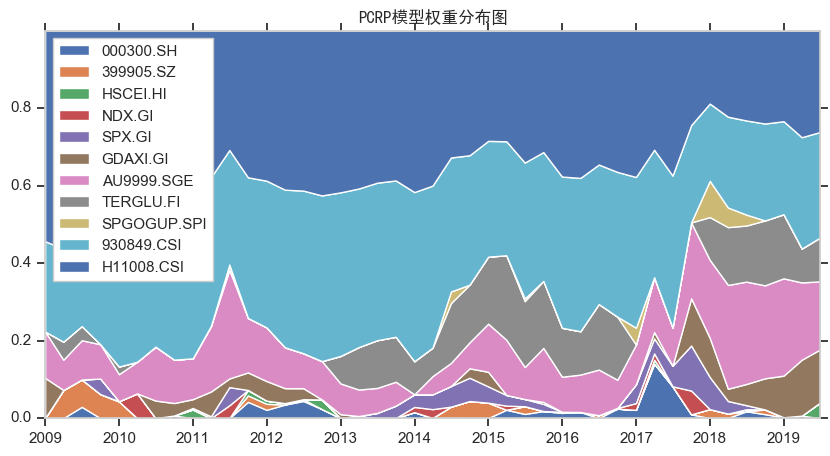

In [197]:
df_weight_pcrp = get_weight_matrix(df,method='pca')
#plt.style.context('Solarize_Light2')
#for i in range(df_weight_pcrp.shape[0]):
#    df_weight_pcrp.iloc[i] = df_weight_pcrp.iloc[i]/df_weight_pcrp.iloc[i].sum()
labels = df_weight_pcrp.columns.to_list()
fig, ax = plt.subplots(figsize=(10,5))
#variable_name = list(dict(df=df).keys())[0]
#variable_name = variable_name.split("_")[-1]
plt.title("PCRP模型权重分布图")
plt.yticks(np.arange(0, 1, step=0.2))
ax.stackplot(df_weight_pcrp.index, df_weight_pcrp.T,baseline='zero',labels=labels)
ax.legend(loc='upper left')
plt.show()

### 2.4 引入预期风险估计：衰减加权法

主成分风险平价仍然没有解决这两个问题，一是没有考虑资产未来收益表现，如果所有资产均下跌，模型依然会给资产分配权重，二是我们使用过去240个交易日

估计协方差矩阵，并进行季度调仓，这隐含着风格持续不变的假设，那么考虑到波动率的聚集性，我们基于资产短期动量的思想，估计协方差矩阵。

以60个交易日为分界，计算每期过去240个交易日的四个阶段协方差$(\Sigma_1,\Sigma_2,\Sigma_3,\Sigma_4)$,

以衰退的权重$(w_1,w_2,w_3,w_4;w_1\ge w_2 \ge w_3 \ge w4;\sum w_i =1)$进行加权形成当期的协方差，即

$$\Sigma_h = w_1\Sigma_1+w_2\Sigma_2+w_3\Sigma_3+w_4\Sigma_4$$

其中$\Sigma_h$表示以衰退权重加权形成的协方差矩阵，其更能反映最近一段时间的市场风格，在此处我们选择的衰退权重为[4/10,3/10,2/10,1/10]。

具体详见《20170918-天风证券-天风证券金工专题报告：基于半衰主成分风险平价模型的全球资产配置策略研究》第14页。

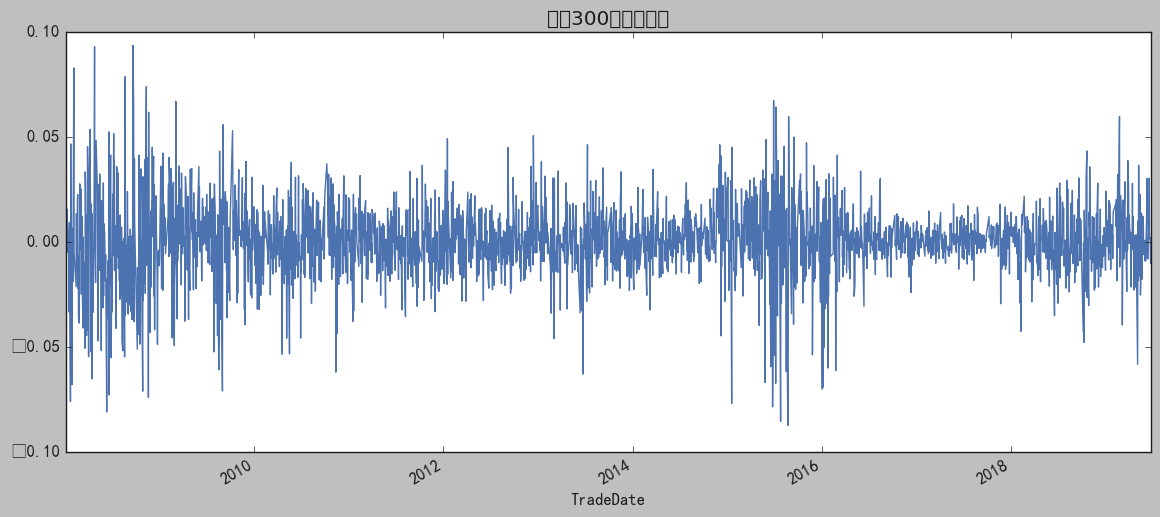

In [198]:
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.figure(figsize = (14,6))
index_return['000300.SH'].plot()
plt.title('沪深300指数收益率')
plt.show()

#### 由上面的时间序列图可以看出，指数很明显存在波动聚集性

在我们之前的分析中，我们隐含的假设了收益率是序列无关的数据，也就是白噪声序列，但是一般来讲金融时间序列常常存在一种波动聚集性

### 半衰主成分风险平价模型 HPCRP

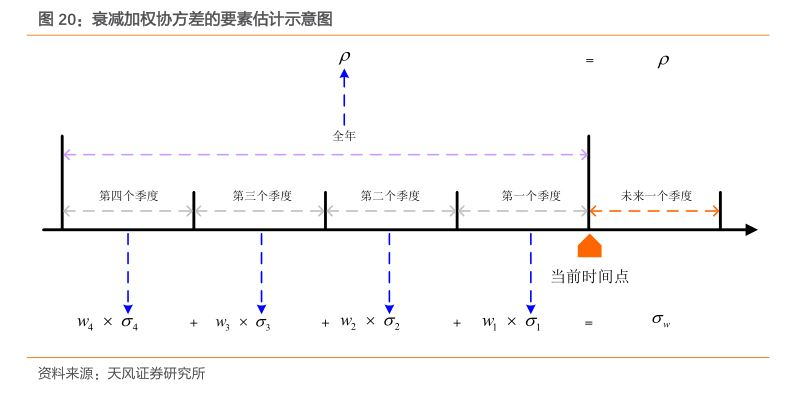

In [199]:
from IPython.display import Image
Image(filename = r'C:\Users\corem\Documents\衰退周期.JPG', width=800, height=200)

In [200]:
def calculate_half_cov_matrix(train_set):
#计算半衰协方差矩阵
    train_subset = train_set.iloc[0:60]
    cov_matrix = calculate_cov_matrix(train_subset)*(1/10)
    for i in range(1,4):
        train_subset = train_set.iloc[i*60:(i+1)*60]
        sub_cov_matrix = calculate_cov_matrix(train_subset)
        if i==1:
            sub_cov_matrix = sub_cov_matrix*(2/10)
        if i==2:
            sub_cov_matrix = sub_cov_matrix*(3/10)
        else:
            sub_cov_matrix = sub_cov_matrix*(4/10)
        cov_matrix = cov_matrix+sub_cov_matrix
    return cov_matrix

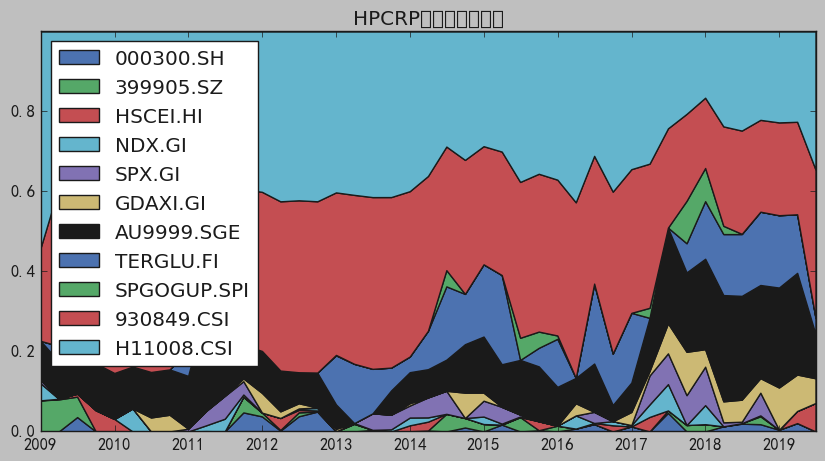

In [201]:
df_weight_hpcrp = get_weight_matrix(df,method='pca',half=True)
#plt.style.context('Solarize_Light2')
#for i in range(df_weight_hpcrp.shape[0]):
#    df_weight_hpcrp.iloc[i] = df_weight_hpcrp.iloc[i]/df_weight_hpcrp.iloc[i].sum()
labels = df_weight_hpcrp.columns.to_list()
fig, ax = plt.subplots(figsize=(10,5))
#variable_name = list(dict(df=df).keys())[0]
#variable_name = variable_name.split("_")[-1]
plt.title("HPCRP模型权重分布图")
plt.yticks(np.arange(0, 1, step=0.2))
ax.stackplot(df_weight_hpcrp.index, df_weight_hpcrp.T,baseline='zero',labels=labels)
ax.legend(loc='upper left')
plt.show()

### 2.5 引入预期走势估计：趋势跟踪法

以某一时间长度的价格移动平均值的哦变化趋势来判断市场趋势。当资产价格上穿周期移动平均线时，可以判断为买入信号；当资产价格下穿周期移动平均线时，

可以判断为卖出信号。

考虑调整周期，假设第t个月末资产价格为p，n个月自动平均价格为MA(n)，则趋势跟踪策略的买卖点可以设置为：

买点：当资产月末价格不低于n月移动平均线，即$p_t \ge MA(n)_t$；

卖点：当资产月末价格低于n月移动平均线，即$p_t<MA(n)_t$。


### 引入预期走势估计改进的主成分风险平价模型  TF-PCRP

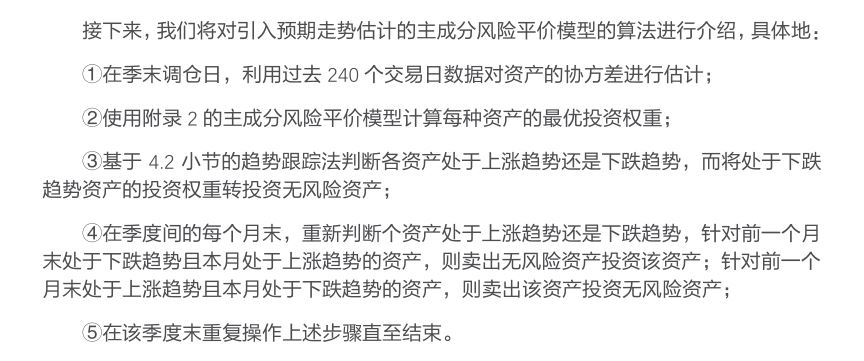

In [202]:
Image(filename = r'C:\Users\corem\Documents\风险平价参考\风险平价参考\改进的主成分风险平价.JPG', width=600, height=200)

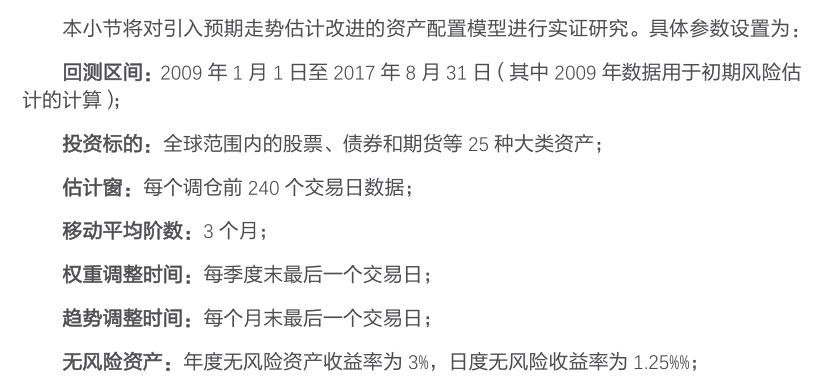

In [203]:
Image(filename = r'C:\Users\corem\Documents\风险平价参考\风险平价参考\预期走势估计的主成分风险平价.JPG', width=600, height=200)

In [204]:
#创建无风险资产序列，设定无风险资产的日收益率是1.25%%
non_risk_array = pd.Series(index=df.index)
rate = 1
i = 1
while i < len(non_risk_array):
    rate = rate*1.000125
    non_risk_array[i] = rate
    i = i +1 

df_ma = df.rolling(60).mean()   #60天移动平均线
df_ma = df_ma.groupby(df.index.to_period("M")).last()  #月末60天移动平均线
df_m = df.groupby(df.index.to_period("M")).last()     #月末交易日指数

#如果df_ma>df_m，则表明改资产应卖出
#如果df_ma>df_m,则为0，否则为1，此时df_ma变为趋势调整矩阵，这样与权重矩阵相乘，相应的权重就会变为0，
for i in df_ma.index.to_list():
    for j in df_ma.columns.to_list():
        if df_ma.loc[i,j] >= df_m.loc[i,j]:
            df_ma.loc[i,j] = 0
        else:
            df_ma.loc[i,j] = 1     

In [205]:
df_weight_pcrp = get_weight_matrix(df,method='pca')   # 获取权重矩阵，日期间隔为季度
df_weight_pcrp.index = df_weight_pcrp.index.to_period("M")    #改变权重矩阵的日期格式为月
monthly_weight = df.groupby(df.index.to_period("M")).last()   #创建日期间隔为月度的权重矩阵
#将df_weight_pcrp的权重插入到monthly_weight
for date in monthly_weight.index:                              
    if date in df_weight_pcrp.index:
        monthly_weight.loc[date] = df_weight_pcrp.loc[date]
    else:
        monthly_weight.loc[date] = np.nan
#补齐缺失值
monthly_weight.fillna(method='bfill',inplace=True)

In [206]:
monthly_weight = monthly_weight['2008-12-31':]
df_ma = df_ma['2008-12-31':]
non_risk_weight = 1-(monthly_weight*df_ma).sum(axis=1)   # 无风险资产权重
monthly_weight = monthly_weight*df_ma
monthly_weight['non_risk'] = non_risk_weight            #添加了无风险资产权重的权重矩阵
monthly_weight.index = monthly_weight.index.to_timestamp(how='end',freq='D')

In [207]:
df_plusnon = df.copy()
df_plusnon['non_risk'] = non_risk_array    # 添加了无风险资产的指数

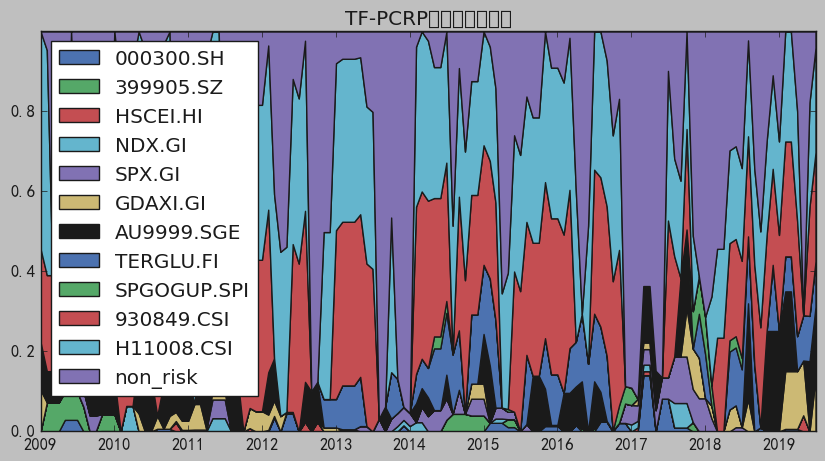

In [208]:
labels = monthly_weight.columns.to_list()
fig, ax = plt.subplots(figsize=(10,5))
plt.title("TF-PCRP模型权重分布图")
plt.yticks(np.arange(0, 1, step=0.2))
ax.stackplot(monthly_weight.index, monthly_weight.T,baseline='zero',labels=labels)
ax.legend(loc='upper left')
plt.show()

### 2.6 引入惩罚项 ： Lasso风险平价 

类似于线性回归，对于我们要优化的目标函数引入一个L1正则项，这样可以使得权重不会太大

In [209]:
# 定义优化问题的目标函数，即最小化资产之间的风险贡献差
def lasso_risk_parity(weight,parameters):
    # weight: 待求解的资产权重,
    # parameters: 参数列表 
    # parameters[0]: 协方差矩阵
    # parameters[1]: 风险平价下的目标风险贡献度向量

    one_cov_matrix=parameters[0]
    RC_target_ratio=parameters[1] 
    # RC_target为风险平价下的目标风险贡献，一旦参数传递以后，RC_target就是一个常数，不随迭代而改变
    sigma_portfolio=np.sqrt(weight*one_cov_matrix*np.matrix(weight).T) # 组合波动率
    RC_target=np.asmatrix(np.multiply(sigma_portfolio,RC_target_ratio))    # 目标风险贡献
    # RC_real是 每次迭代以后最新的真实风险贡献，随迭代而改变
    RC_real=calculate_risk_contribution(weight,one_cov_matrix)
    sum_squared_error= sum(np.square(RC_real-RC_target.T)+np.fabs(weight)*5)[0,0] 
    return sum_squared_error 

In [210]:
df_weight_lasso_rp = get_weight_matrix(df,method='lasso',half=False)

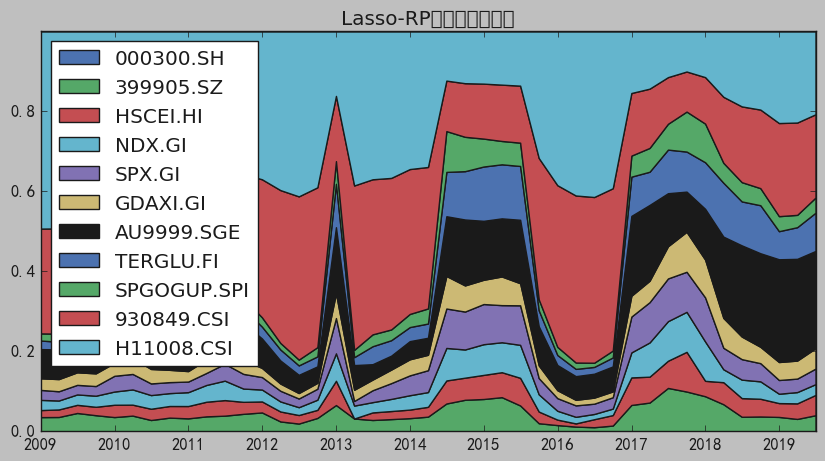

In [211]:
labels = df_weight_lasso_rp.columns.to_list()
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Lasso-RP模型权重分布图")
plt.yticks(np.arange(0, 1, step=0.2))
ax.stackplot(df_weight_lasso_rp.index, df_weight_lasso_rp.T,baseline='zero',labels=labels)
ax.legend(loc='upper left')
plt.show()

## 3 回测



In [212]:
def get_backtest_set(change_time,next_change_time,df):
    """返回回测样本数据"""
    #change_time: 调仓时间
    #next_change_time: 下一次调仓时间
    df = df.loc[(change_time<=df.index)&(df.index<next_change_time)]
    return df 

In [213]:
def get_backtest(df_weight,df):
    change_time_list = df_weight.index.to_list()
    df_b = df.loc['2008-12-31':]
    #df_b = df.loc[(df.index>=change_time_list[0])]   #截取回测区间内的指数,即2018-12-31日开始
    df_b = df_b/df_b.iloc[0]*100     # 统一缩放到100为基点
    backtest = pd.DataFrame(columns=df.columns)  #创建一个空dataframe,用于插入回测数据    
    for i in range(len(change_time_list)-1):
        change_time = change_time_list[i]            #调仓日期
        next_change_time = change_time_list[i+1]     #下一个调仓日期
        #根据调仓时间乘以相应权重
        backtest_set = get_backtest_set(change_time,next_change_time,df_b)
        backtest_set = backtest_set/backtest_set.iloc[0]*100  # 统一缩放到100为基点
        if i == 0 :
            weight = df_weight.loc[change_time]
        else:
            weight = df_weight.loc[change_time]*backtest.iloc[-1].sum()/100
        backtest_set = backtest_set.multiply(weight)
        backtest = backtest.append(backtest_set)
    return backtest  

In [214]:
def make_backtest_result(method_list):
    # Key: 资产组合方法的名字
    # Value is a list
    # value[0]: 具体的结果
    # value[1]: 合并后的结果
    # value[2]: 评价指标
    backtest_result={}
    for method in method_list:
        backtest_result[method]=[None,None,None]
    return backtest_result

In [215]:
def backtest_EW(df):
    """EW的回测结果"""
    ew_weight = ew_weight_matrix(df)
    backtest = get_backtest(ew_weight,df)
    backtest_res['EW'] = backtest.sum(axis=1)
    return backtest

def backtest_RP(df):
    """RP的回测结果"""
    df_weight = get_weight_matrix(df,method=None)
    backtest = get_backtest(df_weight,df)  
    backtest_res['RP'] = backtest.sum(axis=1)
    return backtest

def backtest_PCRP(df):
    """PCRP的回测结果"""
    df_weight = get_weight_matrix(df,method='pca')
    backtest = get_backtest(df_weight,df)
    backtest_res['PCRP'] = backtest.sum(axis=1)
    return backtest

def backtest_HRP(df):
    """HRP回测结果"""
    df_weight = get_weight_matrix(df,method=None,half=True)
    backtest = get_backtest(df_weight,df)
    backtest_res['HRP'] = backtest.sum(axis=1)
    return backtest

def backtest_HPCRP(df):
    """HPCRP回测结果"""
    df_weight = get_weight_matrix(df,method='pca',half=True)
    backtest = get_backtest(df_weight,df)
    backtest_res['HPCRP'] = backtest.sum(axis=1)
    return backtest

def backtest_TF_PCRP(monthly_weight,df_plusnon):
    """TF-PCRP回测结果"""
    backtest = get_backtest(monthly_weight,df_plusnon)
    backtest_res['TF-PCRP'] = backtest.sum(axis=1)
    return backtest 

def backtest_Lasso_RP(df):
    """Lasso-RP回测结果"""
    df_weight = get_weight_matrix(df,method='lasso',half=False)
    backtest = get_backtest(df_weight,df)
    backtest_res['Lasso-RP'] = backtest.sum(axis=1)
    return backtest    

In [216]:
#method_list=['RP','PCRP','HRP','HPCRP']
method_dict={ 'RP':backtest_RP,'PCRP':backtest_PCRP,'HRP':backtest_HRP,'HPCRP':backtest_HPCRP,'Lasso-RP':backtest_Lasso_RP}
backtest_res = pd.DataFrame(columns=method_dict.keys())

In [217]:
c=backtest_TF_PCRP(monthly_weight,df_plusnon)

In [218]:
for name in method_dict:
    method_dict.get(name)(df)

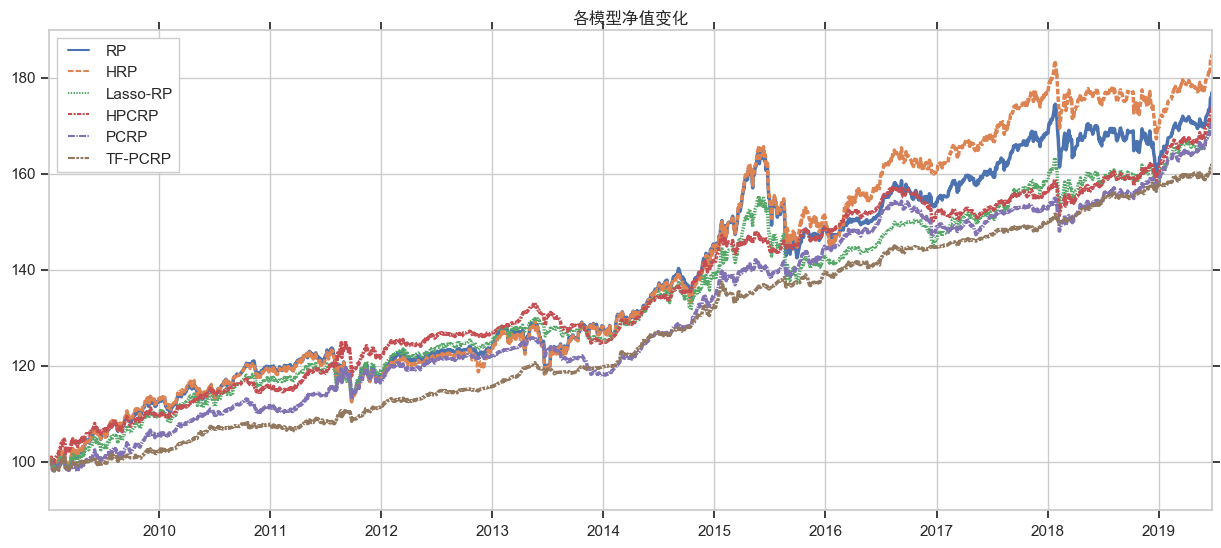

In [219]:
sns.set(style="whitegrid")
plt.figure(figsize = (15,6))
sns.lineplot(data=backtest_res,  linewidth=2.5)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.legend(loc='upper left')
plt.title('各模型净值变化')
plt.show()

## 4 评价指标

#### 计算年化收益率

年化收益率有两种计算方式：

* 算数平均算法：$年化收益率=\frac{R_{T}}{T}*m$
* 几何平均算法：$年化收益率=[(1+R_{T})^\frac{m}{T}]-1$

#### 年华波动率
标准差$\sigma = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(R_{t}-\bar{R})}^2}$

In [220]:
# 计算最大回撤
def max_draw_down(ret): 
    ret = np.array(ret)
    index_j = np.argmax(np.maximum.accumulate(ret) - ret)  # 结束位置
    index_i = np.argmax(ret[:index_j])  # 开始位置
    dd = ret[index_i] - ret[index_j]  # 最大回撤
    dd = dd/ret[index_i]
    return dd,index_i,index_j

In [221]:
def get_eval_indicator(ret):
    """各种评价指标"""
    eval_indicator = pd.Series(index=['累计收益率','年化收益率','年化波动率','最大回撤','sharpe比率','Calmar比率'])
    return_df = get_return_df(ret)
    #累计收益率
    eval_indicator['累计收益率'] = ret.iloc[-1]/ret.iloc[0] - 1
    #年华收益率  
    annual_ret = (ret.iloc[-1]/ret.iloc[0])**(240/ret.shape[0])-1
    eval_indicator['年化收益率'] = annual_ret
    #annual_ret = np.power(1+return_df.mean(), 250)-1 # 几何年化收益
    #年华波动率
    sigma = return_df.std() * (240**0.5)
    eval_indicator['年化波动率'] = sigma
    # 最大回撤
    dd, dd_index_start, dd_index_end = max_draw_down(ret)
    eval_indicator['最大回撤'] = dd
    #夏普比率  无风险利率是3%
    bench_annual_ret = 0.03
    sharpe = (annual_ret-bench_annual_ret)/sigma
    eval_indicator['sharpe比率'] = sharpe
    #Calmar比率=年化收益率/最大历史回撤
    calmar = annual_ret/dd
    eval_indicator['Calmar比率'] = calmar
    return eval_indicator

In [222]:
def get_eval_portfolio(backtest_res):
    """返回各个模型回测的评价结果"""
    eval_portfolio = pd.DataFrame(columns=backtest_res.columns)
    for name in eval_portfolio.columns:
        ret = backtest_res[name]
        eval_portfolio[name] = get_eval_indicator(ret)
    return eval_portfolio

### 各指数收益风险统计

In [223]:
np.around(get_eval_portfolio(data)*100,2)

,000300.SH,399905.SZ,HSCEI.HI,NDX.GI,SPX.GI,GDAXI.GI,AU9999.SGE,TERGLU.FI,SPGOGUP.SPI,930849.CSI,H11008.CSI
累计收益率,101.88,146.26,23.81,511.71,217.58,146.28,66.60,241.70,49.22,46.36,67.38
年化收益率,6.85,8.87,2.03,18.62,11.51,8.87,4.93,12.28,3.85,3.66,4.98
年化波动率,23.98,27.55,24.03,18.18,16.21,19.78,14.55,18.63,21.33,2.72,2.88
最大回撤,46.70,65.20,47.06,22.99,19.78,26.18,44.88,14.65,50.39,8.68,3.03
sharpe比率,16.04,21.29,-4.02,85.89,52.47,29.67,13.26,49.82,3.96,24.14,68.62
Calmar比率,14.66,13.60,4.32,80.99,58.19,33.87,10.98,83.80,7.63,42.11,164.11


### 各模型收益风险统计

In [224]:
np.around(get_eval_portfolio(backtest_res)*100,2)

,RP,HRP,Lasso-RP,HPCRP,PCRP,TF-PCRP
累计收益率,76.03,83.92,71.87,74.21,71.25,62.15
年化收益率,5.47,5.91,5.24,5.37,5.20,4.66
年化波动率,6.03,6.21,4.84,3.74,3.66,2.42
最大回撤,13.68,13.05,11.65,6.33,6.31,3.13
sharpe比率,41.06,46.89,46.23,63.43,60.19,68.72
Calmar比率,40.02,45.30,44.97,84.85,82.43,148.97


## 5 结论

1.从收益率看，引入预期风险估计的半衰风险平价能较好的提升收益率，HRP的收益率高于RP，HPCRP的收益率高于PCRP；

2.从最大回撤和年化波动率看，主成分风险平价能较好的提升净值曲线的稳定性，PCRP和HPCRP的最大回撤和年化波动率均小于RP和HRP；

3.从sharpe比率和calmar比率来看，TF-PCRP最高，它的的最大回测和年化波动率也最小，这似乎说明它是最稳定的，但它的收益也是最低的。
